# Used cars prices analysis

## Problem formulation

The problem at hand isn't really new and it _has been_ tackled numerous times. My guess is that the need for a real system for estimating the prices of used cars isn't the primary force behind this quest. Rather, I believe it is the availability and sheer amount of highly structured data that is available with just a little bit of scraping in every part of the world. Also, we are all car experts, aren't we?

Personally, I really need to part with my old car - a beautiful silver Fiat Stilo with just under 290.000km on it and I have been skimming over the ads for the last couple of months (ok, years), only to see the average price precipitate and further demotivate me to get anything done really. There comes a point in a car's life when it really isn't worth selling anymore, you know that, right? Well, I won't get into that any further, but let's talk a bit about the data _before_ we take a peek at it.

The problem I want to solve is the following:
*given a brand, model, production year, odometer, engine type etc. try to predict as accurately as possible the price of the car*.

It sounds pretty simple and really, it is - I just need a number, a number of euros to be precise. I need a system (mathematical, software, program, whatchamacallit) that will take these inputs, do some magic, and output a prediction or an _estimate_ (although, estimate wouldn't be a wise choice of word in this particular case, because it could get confused with the concept of statistical estimation, and we do not want that).

This particular notebook will deal with the exploration of the scraped data, the so called process of EDA - Exploratory Data Analysis. A really fancy name for some, as it turns out, pretty simple mathematical operations.

We'll import the basic libraries, and I will not get much into the details: a list of software prerequisites and useful resources is in the Appendix A of this series.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

color = sns.color_palette()

import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from pandas_profiling import ProfileReport

color_green='#46b038'

Let's load our dataset and take a closer look.

In [2]:
# raw_data = pd.read_csv('clean.csv');
raw_data = pd.read_csv('all_data.csv');

### Pandas Profiling

[Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) is a very interesting and useful package for pandas that allows us to quickly visualize the data - a special report actually. The report is full of useful information about the columns, the types of variables, the distributions and skewness etc. I imagine it would be a must have for any competition like Kaggle or project on a tight deadline. Tip: try it out.

Now let's run the report.

In [3]:
raw_data.head()

,brand,make,year,price,km,gearbox,doors,imported,kW,cm3,fuel,registered,color,aircon,damage,car_type,standard,drive
0,Hyundai,ix35,2012,9000,143500,M,4/5,0,90,1600.0,petrol,0,GR,4,0,SUV,5,F
1,Citroen,C3,2004,2050,203415,M,4/5,0,50,1398.0,diesel,0,BL,4,0,SDN,3,F
2,Fiat,Doblo,2015,7300,115000,M,4/5,0,55,1248.0,diesel,1,WH,2,0,PU,5,F
3,Citroen,C3,2003,2099,180000,M,4/5,0,44,1124.0,petrol,1,GR,4,0,HB,3,F
4,Opel,Corsa,2007,3000,174000,M,2/3,0,66,1248.0,diesel,1,BL,2,0,HB,4,F


In [4]:
profile = profile = ProfileReport(raw_data)

In [5]:
profile.to_widgets()

### Seaborn plotting & Outlier removal

You *must* know Matplotlib, but you might not know Seaborn. It is very useful and it gives your notebooks and charts a professional look. Oh, it is quite useful too. A guy named Yiannis Pitsillides has a really good and fast youtube series on Seaborn so you should check it out. There are also some cool [cheatsheets](https://www.datacamp.com/community/blog/seaborn-cheat-sheet-python) from Datacamp to get you up and running fast.

#### Price analysis and transformation

The first and also the most important variable, our *target variable* in this analysis is the car price, so it seems logical to start with that.

In [6]:
raw_data.price.describe()

count      7323.000000
mean       5517.203469
std        8658.753195
min           2.000000
25%        2000.000000
50%        3499.000000
75%        6900.000000
max      499990.000000
Name: price, dtype: float64

While the car advertised for half a million euros *does exist* (spoiler: it is a Lambo), the two-euro cars do not. This is an ongoing issue with data validation and users and web forms.

![xkcd](https://imgs.xkcd.com/comics/form.png)

While this could be a case for further investigation, I will just cut left and right and basically say that only cars priced from 500 euros to 30.000 euros are retained. It is a deliberate decision and the beauty of jupyter notebooks is that it could be easily changed or, even better, parametrized in a function.

In [7]:
# sensible defaults
raw_data = raw_data[raw_data.price.between(500,30000)]

In [8]:
raw_data.describe()

,year,price,km,imported,kW,cm3,registered,aircon,damage,standard
count,7082.000000,7082.000000,7.082000e+03,7082.000000,7082.000000,7.082000e+03,7082.000000,7082.000000,7082.000000,7082.000000
mean,2007.354137,5239.973736,1.795739e+05,0.273793,98.493081,2.035133e+03,0.407653,2.852443,0.002400,4.014826
std,5.440409,4610.710009,8.794928e+04,0.445935,922.954639,2.026265e+04,0.491433,1.233781,0.048939,0.971232
min,1972.000000,500.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,2004.000000,2100.000000,1.429420e+05,0.000000,66.000000,1.461000e+03,0.000000,2.000000,0.000000,3.000000
50%,2007.000000,3550.000000,1.780000e+05,0.000000,80.000000,1.689000e+03,0.000000,3.000000,0.000000,4.000000
75%,2011.000000,6900.000000,2.141360e+05,1.000000,102.000000,1.969750e+03,1.000000,4.000000,0.000000,5.000000
max,2019.000000,29999.000000,3.000000e+06,1.000000,77105.000000,1.686980e+06,1.000000,4.000000,1.000000,6.000000


We are seeing gibberish in the *other* columns, but now we are dealing only with price. The next thing to check is the shape of the distribution ot a histogram. [This Kaggle notebook](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) is incredibly useful and thorough and I have stolen more than one trick from it. One of those is the following way to plot the price histogram.

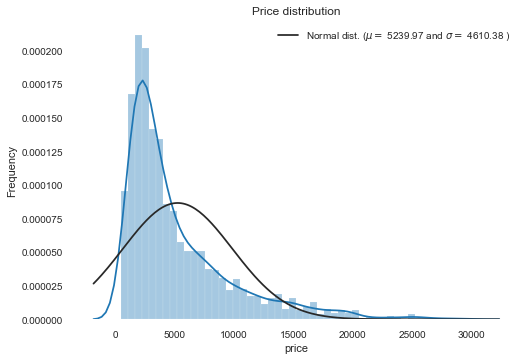

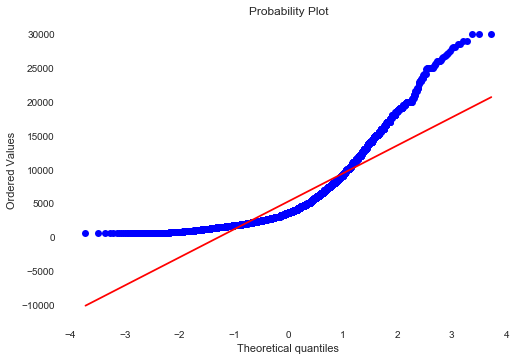

In [9]:
sns.distplot(raw_data.price, fit=norm);
(mu, sigma) = norm.fit(raw_data['price'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(raw_data['price'], plot=plt)
plt.show()

### Skewness and kurtosis

The aformentioned Kaggle notebook states: *The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.* 

This is something I want to leave for later, since I want to save the data _without_ this transformation first.

### Year variable

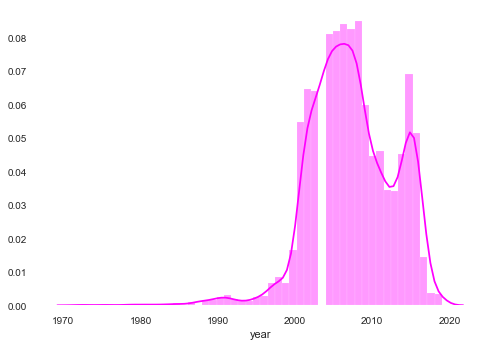

In [10]:
sns.distplot(raw_data.year, color='magenta');

In [11]:
# sensible defaults
raw_data = raw_data[raw_data.year.between(1985,2020)]

In [12]:
raw_data.describe()

,year,price,km,imported,kW,cm3,registered,aircon,damage,standard
count,7067.000000,7067.000000,7.067000e+03,7067.000000,7067.000000,7.067000e+03,7067.000000,7067.000000,7067.000000,7067.000000
mean,2007.413613,5245.379227,1.796637e+05,0.274374,98.590633,2.036221e+03,0.407811,2.858356,0.002406,4.019952
std,5.287811,4611.153625,8.789265e+04,0.446230,923.930242,2.028410e+04,0.491462,1.228334,0.048991,0.964571
min,1985.000000,500.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,2004.000000,2100.000000,1.430000e+05,0.000000,66.000000,1.461000e+03,0.000000,2.000000,0.000000,3.000000
50%,2007.000000,3550.000000,1.780000e+05,0.000000,80.000000,1.689000e+03,0.000000,3.000000,0.000000,4.000000
75%,2011.000000,6900.000000,2.141360e+05,1.000000,102.500000,1.970000e+03,1.000000,4.000000,0.000000,5.000000
max,2019.000000,29999.000000,3.000000e+06,1.000000,77105.000000,1.686980e+06,1.000000,4.000000,1.000000,6.000000


#### Description
- we have lost approximately 200 data points which is quite a lot
- cleaned the outliers but also some perfectly valid points - i.e. cars wich are very old
- I hope that this will facilitate the regression

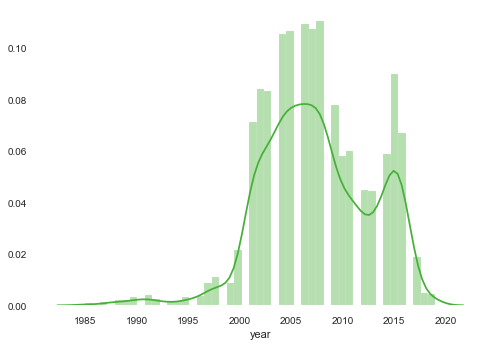

In [13]:
sns.distplot(raw_data.year, color='#46b038');

We could say that this is a bimodal distribution: we can see two spikes - around the 2006 and then 2015. Logically this makes sense: in the majority of cases the cars are either sold after the fist 4-5 years after being acquired and after the end of the warranty period, or when they begin to break down (after 15 years). Unfortunately, my _Stilo 2006_ falls into the second category - the big spike.

### Kilometers

This is probably the most controversial and most _faked_ variable in this dataset. Balkan countries, especially thos which aren't (yet) members of the EU are known for having hundreds if not thousands of cars with tampered odometers. It's one of those things - everybody knows it, the buyers know it, the sellers know it and the authorities know it, but nobody is doing anything about it.

At it's most basic level of observation, the distribution of mileages should be normal - follow the age distribution.

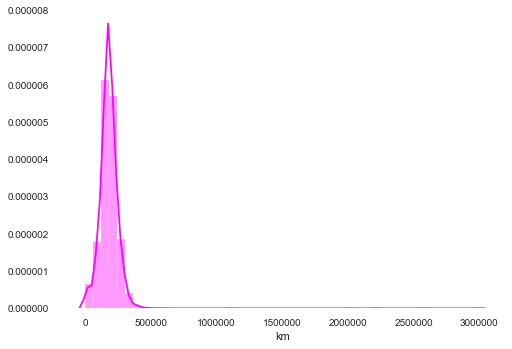

In [14]:
sns.distplot(raw_data.km, color='magenta');

I'll do the same thing: discard some data points and apply a hard filter: any car with a mileage between 3000 and 450000 km will be kept, others must go.

In [15]:
# sensible defaults
raw_data = raw_data[raw_data.km.between(3000,450000)]

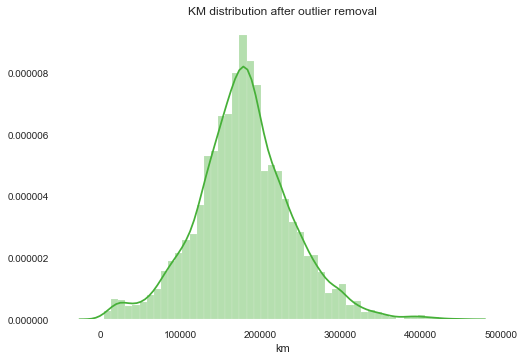

In [16]:
sns.distplot(raw_data.km, color=color_green).set_title("KM distribution after outlier removal");

In [17]:
raw_data.describe()

,year,price,km,imported,kW,cm3,registered,aircon,damage,standard
count,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,6.975000e+03,6975.000000,6975.000000,6975.000000,6975.000000
mean,2007.456057,5261.881864,179568.932330,0.276559,98.738638,2.042698e+03,0.408172,2.860789,0.002151,4.024946
std,5.258616,4602.111371,60059.068553,0.447329,929.959706,2.041725e+04,0.491531,1.226782,0.046327,0.962120
min,1985.000000,500.000000,4600.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,2004.000000,2150.000000,144101.500000,0.000000,66.000000,1.461000e+03,0.000000,2.000000,0.000000,3.000000
50%,2007.000000,3590.000000,178923.000000,0.000000,80.000000,1.689000e+03,0.000000,3.000000,0.000000,4.000000
75%,2011.000000,6950.000000,215000.000000,1.000000,103.000000,1.970000e+03,1.000000,4.000000,0.000000,5.000000
max,2019.000000,29999.000000,450000.000000,1.000000,77105.000000,1.686980e+06,1.000000,4.000000,1.000000,6.000000


We are bleeding data points here and I am well aware of it. All of these *filters* could be and probably should be defined in a more granular and precise way. I am going to keep it for now, but this is like a second checkpoint - a deliberate choice that was made that could potentially affect the results.

#### Replace year with age

I do not want to keep the year variable - instead I will convert it to an age variable.

In [18]:
raw_data['age']=2020-raw_data['year']
raw_data = raw_data.drop(['year'],axis=1)
raw_data.describe()

,price,km,imported,kW,cm3,registered,aircon,damage,standard,age
count,6975.000000,6975.000000,6975.000000,6975.000000,6.975000e+03,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000
mean,5261.881864,179568.932330,0.276559,98.738638,2.042698e+03,0.408172,2.860789,0.002151,4.024946,12.543943
std,4602.111371,60059.068553,0.447329,929.959706,2.041725e+04,0.491531,1.226782,0.046327,0.962120,5.258616
min,500.000000,4600.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2150.000000,144101.500000,0.000000,66.000000,1.461000e+03,0.000000,2.000000,0.000000,3.000000,9.000000
50%,3590.000000,178923.000000,0.000000,80.000000,1.689000e+03,0.000000,3.000000,0.000000,4.000000,13.000000
75%,6950.000000,215000.000000,1.000000,103.000000,1.970000e+03,1.000000,4.000000,0.000000,5.000000,16.000000
max,29999.000000,450000.000000,1.000000,77105.000000,1.686980e+06,1.000000,4.000000,1.000000,6.000000,35.000000


### Kws and cm3s

These two variables - both numerical - are highly correlated: they define the power of the vehicle. I could probably keep just one of them, but I was hoping that their ratio could give me some additional insight into the cars dataset. Newer car models generally manage to squeeze more power out of the same engine displacement (in $cm^3$) so a bigger ratio $kW/cm^3$ theoretically should indicate newer cars... 

The two variables are, however, almost completely correlated and should probably be replaced with just one of them.

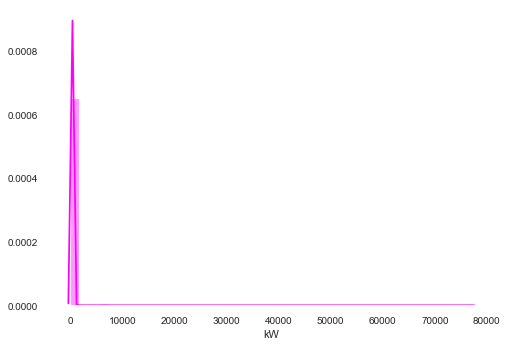

In [19]:
sns.distplot(raw_data.kW, color='magenta');

This is, again, totally arbitrary... I'll just take something that I consider to be a really big car and check it's engine to see what could be a reasonable maximum. For the minimum, I'll settle with a Yugo. Audi A8 quattro - 338 kW and almost 4000 cm3.

For the Yugo, 33kW and 900 cm3 seem to be the specs. I'll take these two models as the two ends of my car spectrum.

In [20]:
# sensible defaults
raw_data = raw_data[raw_data.kW.between(30,400)]

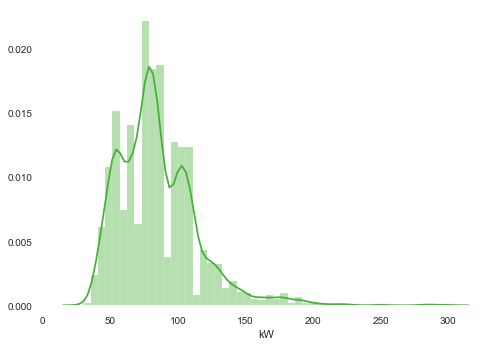

In [21]:
sns.distplot(raw_data.kW, color=color_green);

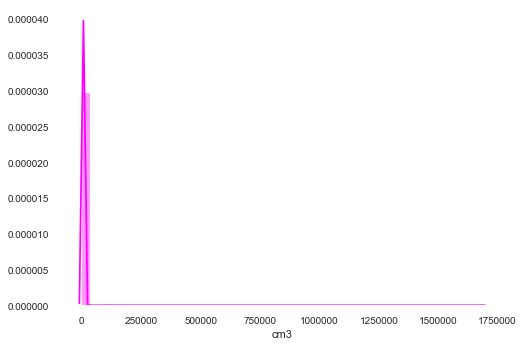

In [22]:
sns.distplot(raw_data.cm3, color='magenta');

In [23]:
# sensible defaults
raw_data = raw_data[raw_data.cm3.between(900,4300)]

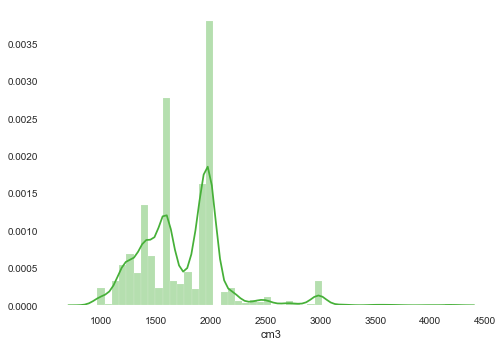

In [24]:
sns.distplot(raw_data.cm3, color=color_green);

This plot makes perfect sense: again we have a bimodal distribution the vast majority of cars uses engines with app. 1900-2000 cm3, or 1.6 litres.

In [25]:
raw_data.describe()

,price,km,imported,kW,cm3,registered,aircon,damage,standard,age
count,6859.000000,6859.000000,6859.000000,6859.000000,6859.000000,6859.000000,6859.000000,6859.000000,6859.000000,6859.000000
mean,5285.426739,179380.007144,0.278320,84.710599,1735.568450,0.408514,2.868786,0.001895,4.032075,12.505030
std,4604.164435,59705.405668,0.448205,28.645907,387.842318,0.491595,1.223131,0.043497,0.959439,5.260391
min,500.000000,4600.000000,0.000000,33.000000,900.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2150.000000,144387.000000,0.000000,66.000000,1461.000000,0.000000,2.000000,0.000000,3.000000,9.000000
50%,3600.000000,178800.000000,0.000000,80.000000,1699.000000,0.000000,3.000000,0.000000,4.000000,13.000000
75%,6950.000000,214024.000000,1.000000,103.000000,1970.000000,1.000000,4.000000,0.000000,5.000000,16.000000
max,29990.000000,440000.000000,1.000000,291.000000,4200.000000,1.000000,4.000000,1.000000,6.000000,35.000000


In [26]:
raw_data.columns

Index(['brand', 'make', 'price', 'km', 'gearbox', 'doors', 'imported', 'kW',
       'cm3', 'fuel', 'registered', 'color', 'aircon', 'damage', 'car_type',
       'standard', 'drive', 'age'],
      dtype='object')

## Scatter plots for numerical data

I will plot some scatter plots in order to see obvious correlations or relationships.

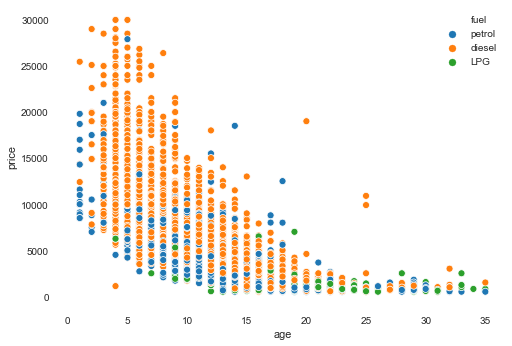

In [27]:
# the pandas plot verison that I do not want to use
#raw_data.plot.scatter(x='age',y='price', alpha=0.7);

# the seaborn version
ax = sns.scatterplot(x="age", y="price",hue="fuel", data=raw_data)

As expected: the price falls pretty fast with the car age. We could further analyze this - it would be nice to compare how different car brands become cheaper with time... And is it true that Volkswagens are champions?

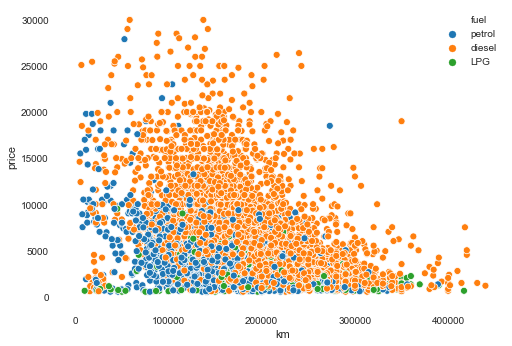

In [28]:
#raw_data.plot.scatter(x='km',y='price');

ax = sns.scatterplot(x="km", y="price", hue="fuel", data=raw_data)

This is where I smell something fishy: it *should* resemble the year/price chart at least partially

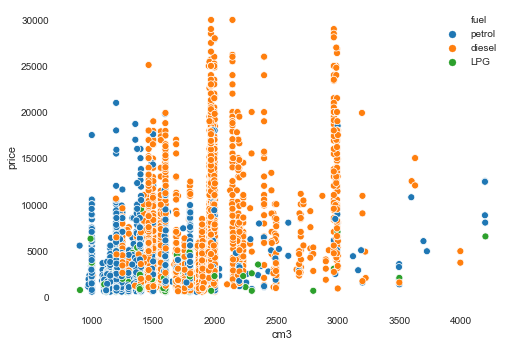

In [29]:
# raw_data.plot.scatter(x='cm3',y='price');

ax = sns.scatterplot(x="cm3", y="price", hue="fuel", data=raw_data)

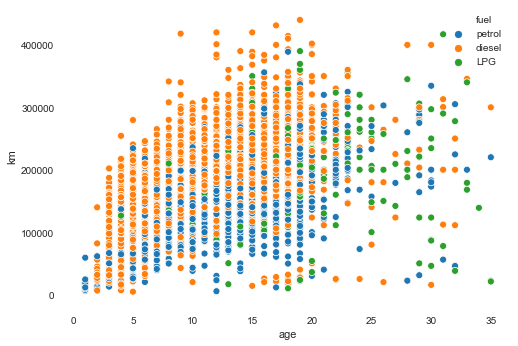

In [30]:
ax = sns.scatterplot(x="age", y="km", hue="fuel", data=raw_data)

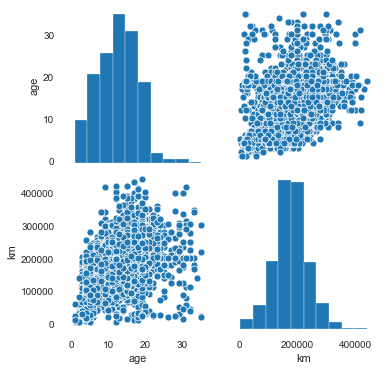

In [31]:
ax = sns.pairplot(raw_data, vars=["age", "km"])

### Correlation heatmap

Finally, I want to see a correlation heatmap with the numerical variables.

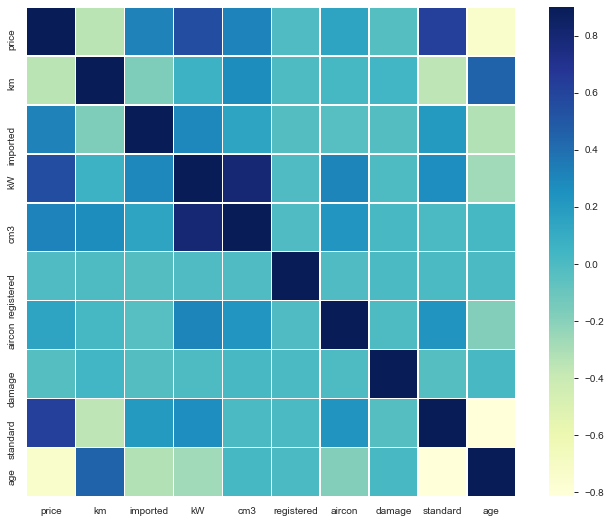

In [32]:
corrmat = raw_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, linewidths=.5, cmap="YlGnBu");

## Categorical features encoding

- Which are the variables
- What do they mean and how they might affect the target

In [33]:
# Let's see the columns again...
raw_data.columns

Index(['brand', 'make', 'price', 'km', 'gearbox', 'doors', 'imported', 'kW',
       'cm3', 'fuel', 'registered', 'color', 'aircon', 'damage', 'car_type',
       'standard', 'drive', 'age'],
      dtype='object')

## Gearbox

The gearbox variable is quite simple:

- M means *manual*
- A means *automatic*
- S means *semiautomatic*

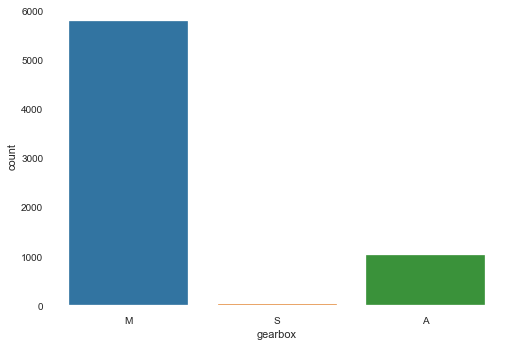

In [34]:
ax = sns.countplot(x="gearbox", data=raw_data)

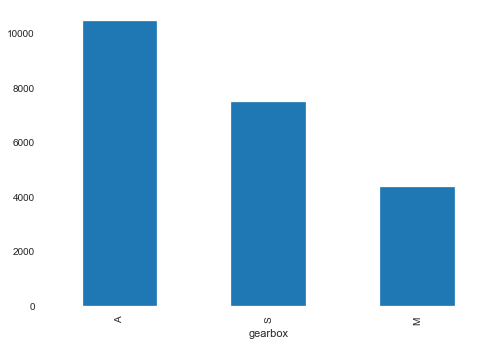

In [35]:
raw_data.groupby('gearbox')['price'].mean().sort_values(ascending=False).plot.bar();

## Answering some questions

It would be silly to pass such a great opportunity to query the dataset and try to obtain some answers that could be potentially interesting:

- who is the most popular manufacturer?
- what about the models?
- petrol or diesel?
- average mileage per car type etc.?

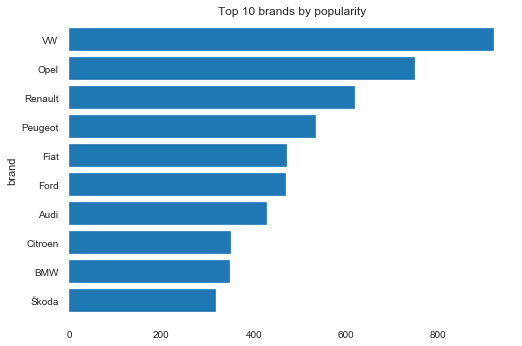

In [36]:
plot_series = raw_data.groupby(['brand'])['price'].count().sort_values(ascending=False)[:10].plot.barh(
    title="Top 10 brands by popularity", width=0.8).invert_yaxis()

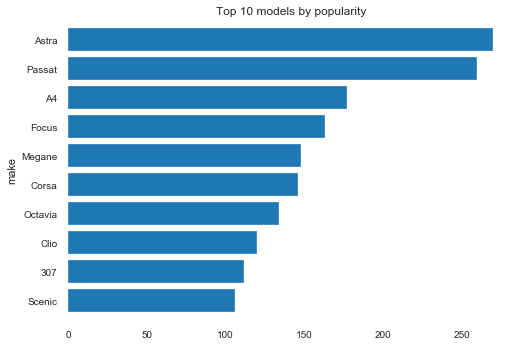

In [37]:
plot_series = raw_data.groupby(['make'])['price'].count().sort_values(ascending=False)[:10].plot.barh(
    title="Top 10 models by popularity", width=0.8).invert_yaxis()

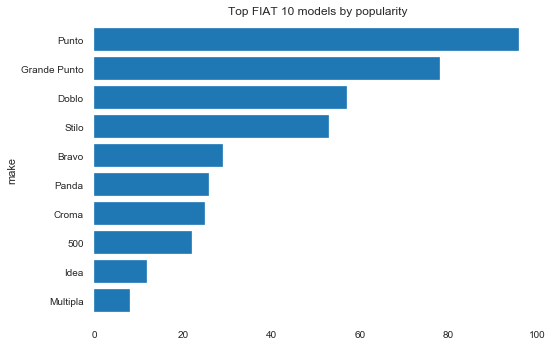

In [38]:
plot_series = raw_data[raw_data['brand']=='Fiat'].groupby(['make'])['price'].count().sort_values(ascending=False)[:10].plot.barh(
    title="Top FIAT 10 models by popularity", width=0.8).invert_yaxis()

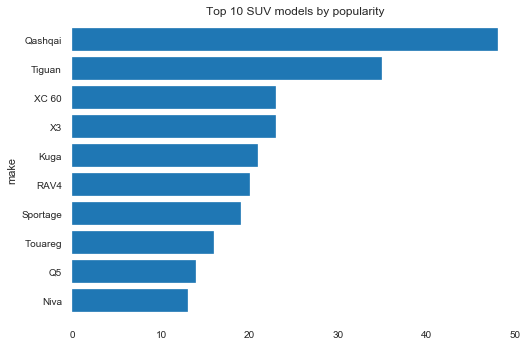

In [39]:
plot_series = raw_data[raw_data['car_type']=='SUV'].groupby(['make'])['price'].count().sort_values(ascending=False)[:10].plot.barh(
    title="Top 10 SUV models by popularity", width=0.8).invert_yaxis()

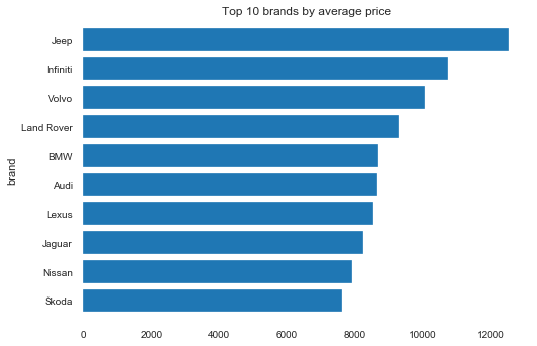

In [40]:
plot_series = raw_data.groupby(['brand'])['price'].mean().sort_values(ascending=False)[:10].plot.barh(
    title="Top 10 brands by average price", width=0.8).invert_yaxis()

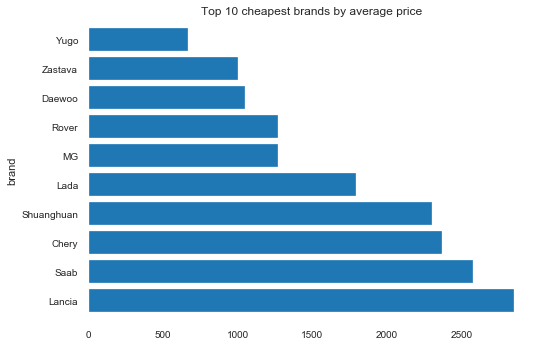

In [41]:
plot_series = raw_data.groupby(['brand'])['price'].mean().sort_values(ascending=True)[:10].plot.barh(
    title="Top 10 cheapest brands by average price", width=0.8).invert_yaxis()

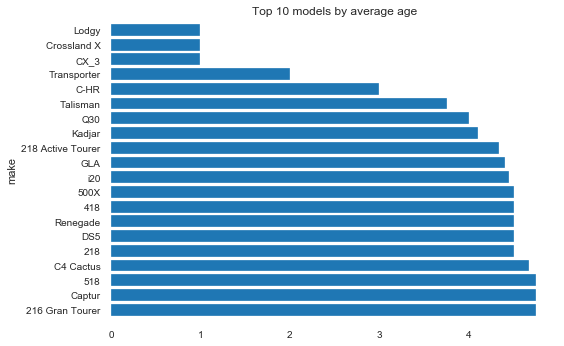

In [42]:
plot_series = raw_data.groupby(['make'])['age'].mean().sort_values(ascending=True)[:20].plot.barh(
    title="Top 10 models by average age", width=0.8).invert_yaxis()

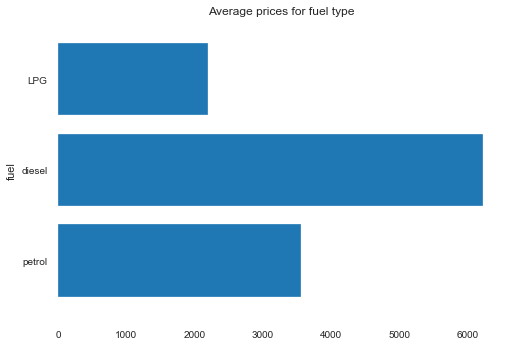

In [43]:
plot_series = raw_data.groupby(['fuel'])['price'].mean().plot.barh(
    title="Average prices for fuel type", width=0.8).invert_yaxis()

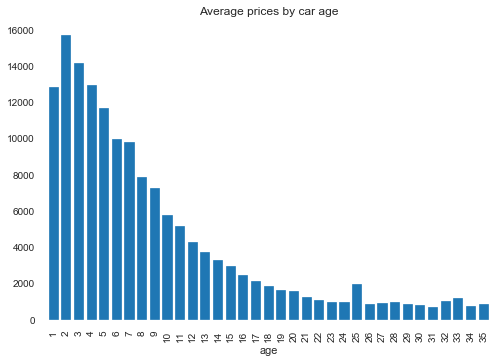

In [44]:
plot_series = raw_data.groupby(['age'])['price'].mean().plot.bar(
    title="Average prices by car age", width=0.8)

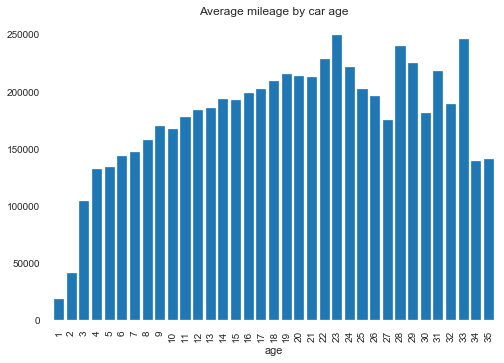

In [45]:
plot_series = raw_data.groupby(['age'])['km'].mean().plot.bar(
    title="Average mileage by car age", width=0.8)

### Additional column - country

I believe that there is an implicit information hidden in the brand's country of origin. Some people simply prefer german cars, there is a pretty strong _french cluster_ - people who worship the Peugeot/Citroen/Renault vehicles, there might be a tiny italian niche as well. I will add a new variable denoted **country** and then hot-enode it with the others.

In [46]:
raw_data['brand'].value_counts()

VW            921
Opel          750
Renault       620
Peugeot       536
Fiat          473
Ford          470
Audi          428
Citroen       351
BMW           348
Škoda         318
Mercedes      318
Seat          145
Nissan        119
Mazda         111
Toyota        103
Alfa Romeo    100
Hyundai        92
Volvo          83
Kia            77
Honda          50
Chevrolet      49
Mitsubishi     46
Suzuki         43
Dacia          43
Lancia         39
MINI           27
Jeep           24
Lada           22
Land Rover     20
Zastava        19
Yugo           17
Subaru         16
Jaguar         12
Chrysler       12
Daewoo         12
Saab           10
Rover           7
Daihatsu        6
SsangYong       5
Smart           5
Dodge           4
Infiniti        2
Chery           2
Tata            1
Lexus           1
MG              1
Shuanghuan      1
Name: brand, dtype: int64

In [47]:
german = ['vw','opel','audi','bmw','mercedes','mini']
italian = ['fiat','alfa romeo','lancia']
french = ['peugeot','renault','citroen']
asian = ['toyota','nissan','mazda','hyundai','kia','mitsubishi','daewoo','daihatsu','honda','subaru','suzuki']
usa = ['ford','dodge','chrysler','chevrolet']
eu = ['škoda','seat','dacia','jaguar','rover','smart','saab']
yussr = ['yugo','zastava','lada']

def get_country(item):
    if item.lower() in german:
        return 'German'
    if item.lower() in italian:
        return 'Italian'
    if item.lower() in french:
        return 'French'
    if item.lower() in asian:
        return 'Asian'
    if item.lower() in usa:
        return 'USA'
    if item.lower() in eu:
        return 'EU'
    if item.lower() in yussr:
        return 'YuSSR'
    return "Other"

raw_data['country'] = raw_data['brand'].apply(get_country)

In [48]:
raw_data.sample(10)

,brand,make,price,km,gearbox,doors,imported,kW,cm3,fuel,registered,color,aircon,damage,car_type,standard,drive,age,country
4591,Renault,Scenic,1650,250000,M,4/5,0,88,1870.0,diesel,1,GR,2,0,VAN,3,F,16,French
2544,Alfa Romeo,MiTo,3730,165500,M,2/3,1,99,1368.0,petrol,0,BL,4,0,SM,5,F,10,Italian
4210,Ford,Maverick,4000,175000,M,4/5,0,90,2000.0,LPG,1,VAR,2,0,SUV,3,4x4,16,USA
5563,Peugeot,406,2000,230000,M,4/5,0,81,1989.0,diesel,0,VAR,2,0,SDN,3,F,18,French
2004,Peugeot,508,15500,97000,A,4/5,0,133,1997.0,diesel,1,GR,4,0,SDN,6,F,5,French
4243,Honda,CR_V,4100,250000,M,4/5,0,103,2204.0,diesel,0,GR,2,0,SUV,3,4x4,15,Asian
2235,Renault,Megane,7940,79000,M,4/5,1,110,1461.0,diesel,0,WH,4,0,SW,6,F,5,French
6698,BMW,218 Active Tourer,12700,170000,A,4/5,0,110,1995.0,diesel,1,WH,4,0,VAN,6,F,4,German
3958,Škoda,Octavia,6880,132170,M,4/5,1,90,1390.0,petrol,0,VAR,3,0,SW,4,F,8,EU
5190,Škoda,Superb,8990,165201,M,4/5,1,76,1598.0,diesel,0,VAR,0,0,SW,5,F,7,EU


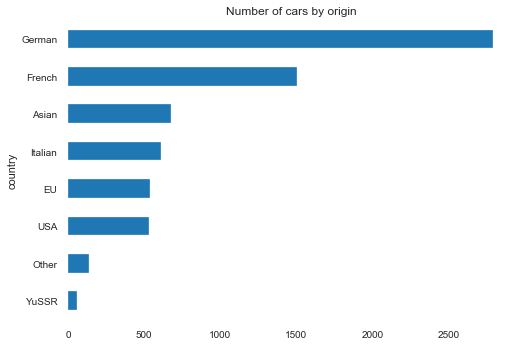

In [49]:
raw_data.groupby(['country'])['price'].count().sort_values(ascending=True).plot.barh(title='Number of cars by origin');

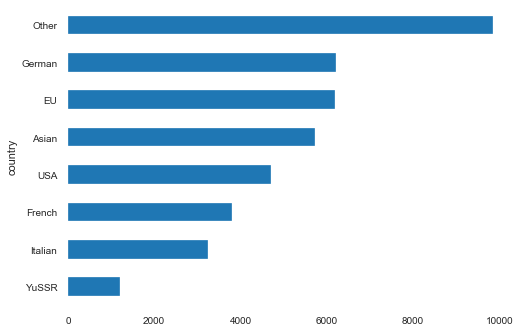

In [50]:
raw_data.groupby(['country'])['price'].mean().sort_values(ascending=True).plot.barh();

This all country thing is obviously very arbitrary, but I believe it could help the model in some way and the prices seem to indicate this.

### Encoding the categorical variables
- One Hot encoding with dropping
- Save one csv file _without_ encoding: for CatBoost or different encodings

In [51]:
raw_data.to_csv('data_with_categories.csv',index=False)

In [52]:
#df = pd.concat([df,pd.get_dummies(df['mycol'], prefix='mycol',dummy_na=True)],axis=1).drop(['mycol'],axis=1)

raw_data = pd.concat([raw_data, pd.get_dummies(raw_data['gearbox'],prefix='gearbox', drop_first=True)], axis=1).drop(['gearbox'], axis=1)

In [53]:
raw_data.sample(20)

,brand,make,price,km,doors,imported,kW,cm3,fuel,registered,color,aircon,damage,car_type,standard,drive,age,country,gearbox_M,gearbox_S
4966,BMW,318,5600,199000,4/5,0,105,1995.0,diesel,0,GR,4,0,SDN,4,B,13,German,1,0
3510,Audi,Q5,19700,150690,4/5,1,129,1968.0,diesel,1,GR,3,0,SUV,5,4x4,6,German,0,0
5248,Opel,Astra,7555,69000,4/5,0,100,1598.0,diesel,0,GR,2,0,SW,6,F,5,German,1,0
693,Opel,Astra,7799,167505,4/5,0,81,1598.0,diesel,0,VAR,4,0,HB,6,F,5,German,1,0
3667,BMW,318,9000,190000,4/5,0,105,1995.0,diesel,0,VAR,4,0,SW,5,B,9,German,1,0
6271,BMW,320,5200,260000,4/5,0,120,1998.0,diesel,0,VAR,4,0,SDN,4,B,14,German,1,0
2191,Renault,Captur,9990,114781,4/5,0,66,1461.0,diesel,0,BL,4,0,SUV,6,F,4,French,1,0
3721,Mercedes,A 180,3999,188846,4/5,1,79,1991.0,diesel,1,BL,3,0,VAN,4,F,15,German,0,0
3071,Ford,Fiesta,4650,131000,4/5,0,50,1399.0,diesel,0,WH,4,0,SDN,3,F,11,USA,1,0
4286,Škoda,Superb,18499,105210,4/5,1,110,1986.0,diesel,0,BL,3,0,SW,5,F,4,EU,1,0


In [54]:
# repeat for other categoricals
categoricals = ['brand','make','doors', 'imported','fuel', 'color', 'aircon', 'car_type', 'drive','country']

In [55]:
for cat in categoricals:
    print("One hot encoding category: ", cat)
    raw_data = pd.concat([raw_data, pd.get_dummies(raw_data[cat],prefix=cat, drop_first=True)], axis=1).drop([cat], axis=1)

One hot encoding category:  brand
One hot encoding category:  make
One hot encoding category:  doors
One hot encoding category:  imported
One hot encoding category:  fuel
One hot encoding category:  color
One hot encoding category:  aircon
One hot encoding category:  car_type
One hot encoding category:  drive
One hot encoding category:  country


In [56]:
raw_data.head()

,price,km,kW,cm3,registered,damage,standard,age,gearbox_M,gearbox_S,...,car_type_VAN,drive_B,drive_F,country_EU,country_French,country_German,country_Italian,country_Other,country_USA,country_YuSSR
0,9000,143500,90,1600.0,0,0,5,8,1,0,...,0,0,1,0,0,0,0,0,0,0
1,2050,203415,50,1398.0,0,0,3,16,1,0,...,0,0,1,0,1,0,0,0,0,0
2,7300,115000,55,1248.0,1,0,5,5,1,0,...,0,0,1,0,0,0,1,0,0,0
3,2099,180000,44,1124.0,1,0,3,17,1,0,...,0,0,1,0,1,0,0,0,0,0
4,3000,174000,66,1248.0,1,0,4,13,1,0,...,0,0,1,0,0,1,0,0,0,0


In [57]:
for col in raw_data.columns:
    print(col)

price
km
kW
cm3
registered
damage
standard
age
gearbox_M
gearbox_S
brand_Audi
brand_BMW
brand_Chery
brand_Chevrolet
brand_Chrysler
brand_Citroen
brand_Dacia
brand_Daewoo
brand_Daihatsu
brand_Dodge
brand_Fiat
brand_Ford
brand_Honda
brand_Hyundai
brand_Infiniti
brand_Jaguar
brand_Jeep
brand_Kia
brand_Lada
brand_Lancia
brand_Land Rover
brand_Lexus
brand_MG
brand_MINI
brand_Mazda
brand_Mercedes
brand_Mitsubishi
brand_Nissan
brand_Opel
brand_Peugeot
brand_Renault
brand_Rover
brand_Saab
brand_Seat
brand_Shuanghuan
brand_Smart
brand_SsangYong
brand_Subaru
brand_Suzuki
brand_Tata
brand_Toyota
brand_VW
brand_Volvo
brand_Yugo
brand_Zastava
brand_Škoda
make_100
make_101
make_106
make_107
make_108
make_110
make_111
make_112
make_116
make_118
make_120
make_145
make_147
make_156
make_159
make_180
make_190
make_2
make_200
make_2008
make_206
make_207
make_207 CC
make_208
make_216
make_216 Gran Tourer
make_218
make_218 Active Tourer
make_220
make_250
make_3
make_3008
make_300C
make_300M
make_301
make_3

In [58]:
len(raw_data.columns)

587

### Saving two datasets

I will save one dataset wich I am going to call **ready.csv** with the transformed data. The other dataset will be called **ready_t.csv** and there I will perform a log1 transformation of the target variable (price).

In [59]:
# save the cleaned but not transformed data...
raw_data.to_csv('ready_full_dataset.csv',index=False)


 mu = 8.25 and sigma = 0.81



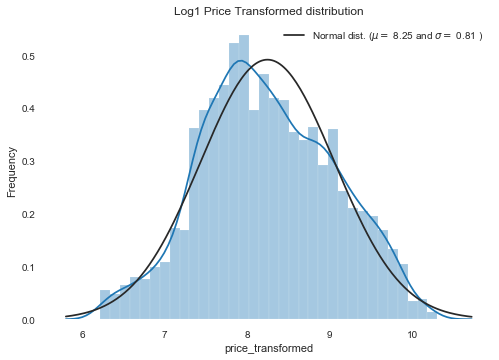

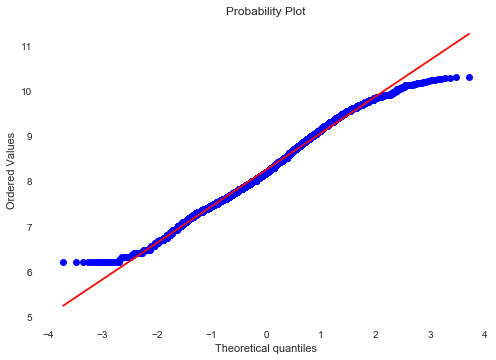

In [60]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
raw_data["price_transformed"] = np.log1p(raw_data["price"])

#Check the new distribution 
sns.distplot(raw_data['price_transformed'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(raw_data['price_transformed'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log1 Price Transformed distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(raw_data['price_transformed'], plot=plt)
plt.show()

In [61]:
 raw_data[['price','price_transformed']].head()

,price,price_transformed
0,9000,9.105091
1,2050,7.626083
2,7300,8.895767
3,2099,7.649693
4,3000,8.006701


In [62]:
# save the cleaned AND transformed data...
raw_data.to_csv('ready_t.csv',index=False)

That's it for the first part. We have a dataset (the file ready_t.csv really holds all the relevant data, transformed and not).